## These models predict deltaI, deltaR, and the scale factor using training data created with the MATLAB code HexagonSpec_TrainingData_PS. 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 
peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
# energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

#col_names2 = ['deltaI', 'deltaR', 'scale factor']+ peak_names + locs_names + width_names + prom_names
#col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names

col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 
col_names2 = ['deltaI', 'deltaR']+ peak_names + locs_names + width_names + prom_names # this one would be used if we didn't have the scale factor 
# col_names_both = col_names2 + energy_names2 # this would be used if we wanted to exclude the first peak specs 
col_names_both = col_names2 + energy_names


In [3]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180727_PS_sf_0.8993_specPoints.csv', header = None, names = col_names1)
# Peak Info 
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180727_PS_sf_0.8993_peakinfo.csv', header = None, names = col_names2)


In [4]:
# Manipulating Training Data 
# col_names1a = ['deltaI', 'deltaR'] + energy_names[50:] # this would be used if we wanted to exclude the first peak 
# data1 = data1[col_names1a] # this would be used if we wanted to exclude the first peak 

# Making combination data peak info + spec points  
data = data2.join(data1.drop(['deltaI', 'deltaR'], axis = 1), how = 'left')
data = data[col_names_both]

X1 = data1.drop(['deltaI', 'deltaR'], axis = 1)
Y1 = data1[['deltaI', 'deltaR']]

# X2 = data2.drop(['deltaI', 'deltaR', 'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
X2 = data2.drop(['deltaI', 'deltaR'], axis = 1)
Y2 = data2[['deltaI', 'deltaR']]

# X = data.drop(['deltaI', 'deltaR', 'peak1', 'prom1', 'loc1', 'width1'], axis = 1) used if we don't want peak 1 info 
X = data.drop(['deltaI', 'deltaR'], axis = 1)
Y = data[['deltaI', 'deltaR']]

In [5]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

In [6]:
# Checking Combination Data
data.head()

,deltaI,deltaR,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,5.5470,3.6106,2.7983,2.0825,-0.336,-0.200,-0.008,0.230,...,1.3526,1.3974,1.4409,1.4820,1.5188,1.5516,1.5787,1.5992,1.6122,1.6180
1,0.91338,-0.57749,6.9093,4.4682,3.4129,2.4882,-0.336,-0.200,-0.008,0.230,...,1.4546,1.5256,1.5958,1.6632,1.7241,1.7783,1.8221,1.8536,1.8711,1.8744
2,0.27850,-0.71176,12.8380,8.3216,6.1374,4.2867,-0.338,-0.204,-0.016,0.220,...,2.7494,2.8964,2.9791,2.9808,2.9037,2.7594,2.5686,2.3562,2.1371,1.9294
3,0.96489,-1.32320,8.2228,5.2647,3.9644,2.8902,-0.336,-0.198,-0.004,0.234,...,1.2344,1.3178,1.4074,1.5031,1.6012,1.7025,1.8026,1.8971,1.9822,2.0530
4,0.95717,-0.80837,7.6171,4.8715,3.6899,2.6824,-0.336,-0.200,-0.008,0.230,...,1.4186,1.5017,1.5866,1.6714,1.7516,1.8270,1.8924,1.9447,1.9811,1.9998


In [7]:
# Checking Combination Data 
X.head()

,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,5.5470,3.6106,2.7983,2.0825,-0.336,-0.200,-0.008,0.230,0.012659,0.025662,...,1.3526,1.3974,1.4409,1.4820,1.5188,1.5516,1.5787,1.5992,1.6122,1.6180
1,6.9093,4.4682,3.4129,2.4882,-0.336,-0.200,-0.008,0.230,0.010314,0.021022,...,1.4546,1.5256,1.5958,1.6632,1.7241,1.7783,1.8221,1.8536,1.8711,1.8744
2,12.8380,8.3216,6.1374,4.2867,-0.338,-0.204,-0.016,0.220,0.005698,0.011447,...,2.7494,2.8964,2.9791,2.9808,2.9037,2.7594,2.5686,2.3562,2.1371,1.9294
3,8.2228,5.2647,3.9644,2.8902,-0.336,-0.198,-0.004,0.234,0.008822,0.018226,...,1.2344,1.3178,1.4074,1.5031,1.6012,1.7025,1.8026,1.8971,1.9822,2.0530
4,7.6171,4.8715,3.6899,2.6824,-0.336,-0.200,-0.008,0.230,0.009452,0.019421,...,1.4186,1.5017,1.5866,1.6714,1.7516,1.8270,1.8924,1.9447,1.9811,1.9998


In [8]:
# Checking Spec points Data 
X1.head()

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.180250,0.16448,0.153370,0.145700,0.140760,0.137740,0.136630,0.137150,0.139210,0.142780,...,1.3526,1.3974,1.4409,1.4820,1.5188,1.5516,1.5787,1.5992,1.6122,1.6180
1,0.140750,0.12851,0.119900,0.114030,0.110300,0.108040,0.107310,0.107850,0.109620,0.112590,...,1.4546,1.5256,1.5958,1.6632,1.7241,1.7783,1.8221,1.8536,1.8711,1.8744
2,0.070673,0.06502,0.061142,0.058558,0.057090,0.056281,0.056309,0.056971,0.058366,0.060378,...,2.7494,2.8964,2.9791,2.9808,2.9037,2.7594,2.5686,2.3562,2.1371,1.9294
3,0.118010,0.10723,0.099621,0.094447,0.091096,0.088948,0.088087,0.088310,0.089489,0.091672,...,1.2344,1.3178,1.4074,1.5031,1.6012,1.7025,1.8026,1.8971,1.9822,2.0530
4,0.128690,0.11734,0.109360,0.103920,0.100450,0.098310,0.097573,0.098008,0.099546,0.102180,...,1.4186,1.5017,1.5866,1.6714,1.7516,1.8270,1.8924,1.9447,1.9811,1.9998


In [9]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.180250,0.16448,0.153370,0.145700,0.140760,0.137740,0.136630,0.137150,...,1.3526,1.3974,1.4409,1.4820,1.5188,1.5516,1.5787,1.5992,1.6122,1.6180
1,0.91338,-0.57749,0.140750,0.12851,0.119900,0.114030,0.110300,0.108040,0.107310,0.107850,...,1.4546,1.5256,1.5958,1.6632,1.7241,1.7783,1.8221,1.8536,1.8711,1.8744
2,0.27850,-0.71176,0.070673,0.06502,0.061142,0.058558,0.057090,0.056281,0.056309,0.056971,...,2.7494,2.8964,2.9791,2.9808,2.9037,2.7594,2.5686,2.3562,2.1371,1.9294
3,0.96489,-1.32320,0.118010,0.10723,0.099621,0.094447,0.091096,0.088948,0.088087,0.088310,...,1.2344,1.3178,1.4074,1.5031,1.6012,1.7025,1.8026,1.8971,1.9822,2.0530
4,0.95717,-0.80837,0.128690,0.11734,0.109360,0.103920,0.100450,0.098310,0.097573,0.098008,...,1.4186,1.5017,1.5866,1.6714,1.7516,1.8270,1.8924,1.9447,1.9811,1.9998


In [10]:
# Checking Peak Info Data 
X2.head()

,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,5.5470,3.6106,2.7983,2.0825,-0.336,-0.200,-0.008,0.230,0.012659,0.025662,0.037115,0.045755,5.3263,3.2319,2.2590,1.3712
1,6.9093,4.4682,3.4129,2.4882,-0.336,-0.200,-0.008,0.230,0.010314,0.021022,0.031356,0.039306,6.7322,4.1567,2.9598,1.8473
2,12.8380,8.3216,6.1374,4.2867,-0.338,-0.204,-0.016,0.220,0.005698,0.011447,0.018048,0.024110,12.7440,8.1493,5.8797,3.8587
3,8.2228,5.2647,3.9644,2.8902,-0.336,-0.198,-0.004,0.234,0.008822,0.018226,0.027718,0.034997,8.0727,4.9983,3.5689,2.3153
4,7.6171,4.8715,3.6899,2.6824,-0.336,-0.200,-0.008,0.230,0.009452,0.019421,0.029347,0.036992,7.4543,4.5837,3.2676,2.0730


In [11]:
# Checking Peak Info Data 
data2.head()

,deltaI,deltaR,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,0.81472,-0.14798,5.5470,3.6106,2.7983,2.0825,-0.336,-0.200,-0.008,0.230,0.012659,0.025662,0.037115,0.045755,5.3263,3.2319,2.2590,1.3712
1,0.91338,-0.57749,6.9093,4.4682,3.4129,2.4882,-0.336,-0.200,-0.008,0.230,0.010314,0.021022,0.031356,0.039306,6.7322,4.1567,2.9598,1.8473
2,0.27850,-0.71176,12.8380,8.3216,6.1374,4.2867,-0.338,-0.204,-0.016,0.220,0.005698,0.011447,0.018048,0.024110,12.7440,8.1493,5.8797,3.8587
3,0.96489,-1.32320,8.2228,5.2647,3.9644,2.8902,-0.336,-0.198,-0.004,0.234,0.008822,0.018226,0.027718,0.034997,8.0727,4.9983,3.5689,2.3153
4,0.95717,-0.80837,7.6171,4.8715,3.6899,2.6824,-0.336,-0.200,-0.008,0.230,0.009452,0.019421,0.029347,0.036992,7.4543,4.5837,3.2676,2.0730


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.00990512661291014 for  deltaI Depth 60
R^2 Score on test data: 0.9987984883479789 for deltaI Depth 60
 
RMSE on test data: 0.010805509075552933 for  deltaR Depth 60
R^2 Score on test data: 0.9994354754149963 for deltaR Depth 60


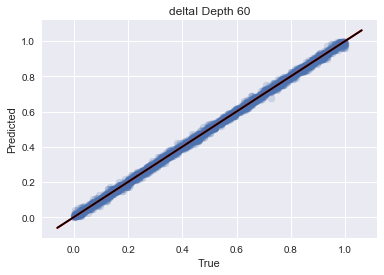

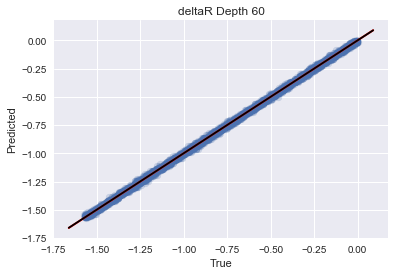

In [12]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
# plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [13]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)

### peak info

 
RMSE on test data: 0.01265600355568538 for  deltaI Depth 60
R^2 Score on test data: 0.9980384422413475 for deltaI Depth 60
 
RMSE on test data: 0.015350526459056506 for  deltaR Depth 60
R^2 Score on test data: 0.9988606977779755 for deltaR Depth 60


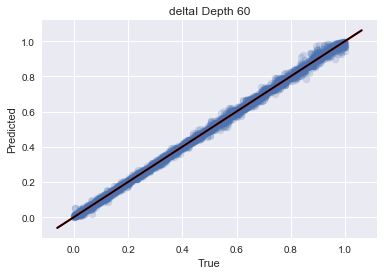

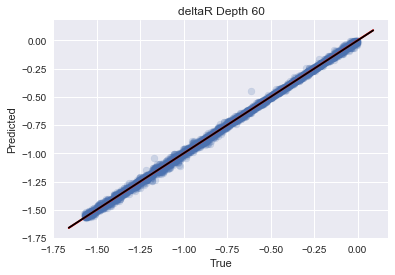

In [14]:
#Initialize the model
rs = 42
regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_pi = regr_DT_pi.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
# plotSummary(Y2_test['scale factor'], predictions_DT_pi[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [15]:
# peak info decision tree feature importances 
FI_pi_DT = pd.DataFrame(regr_DT_pi.feature_importances_.T, columns = ['Peak - DT'])
FI_pi_DT.index = X2_train.columns

#print(FI_pi_DT[FI_sp_DT['Peak - DT']>0.001])
features_pi_DT = (FI_pi_DT[FI_pi_DT['Peak - DT']>0.006])
features_pi_DT_sorted = features_pi_DT.sort_values('Peak - DT', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.009926716398646944 for  deltaI Depth 60
R^2 Score on test data: 0.9987932448714003 for deltaI Depth 60
 
RMSE on test data: 0.010553848401855708 for  deltaR Depth 60
R^2 Score on test data: 0.9994614647959134 for deltaR Depth 60


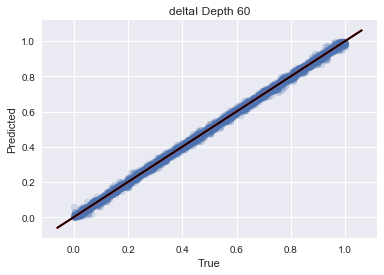

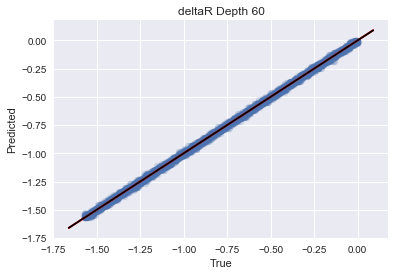

In [16]:
#Initialize the model
rs = 42
regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_both = regr_DT_both.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y_test['scale factor'], predictions_DT_both[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [17]:
# combined info decision tree feature importances 
FI_b_DT = pd.DataFrame(regr_DT_both.feature_importances_.T, columns = ['Both - DT'])
FI_b_DT.index = X_train.columns

#print(FI_b_DT[FI_b_DT['Both - DT']>0.001])
features_b_DT = (FI_b_DT[FI_b_DT['Both - DT']>0.006])
features_b_DT_sorted = features_b_DT.sort_values('Both - DT', ascending = False)

In [18]:
display_side_by_side(features_sp_DT_sorted, features_b_DT_sorted, features_pi_DT_sorted,)

,Spec - DT
E_462_mV,0.536643
E_-282_mV,0.115879
E_-192_mV,0.098535
E_402_mV,0.036128
E_54_mV,0.035889
E_424_mV,0.035645
E_-154_mV,0.025740
E_230_mV,0.009465
E_-168_mV,0.007842
E_-328_mV,0.007690


## Random Forest

### spec points

 
RMSE on test data: 0.0033092878208479215 for  deltaI RF spec
R^2 Score on test data: 0.9998658851073824 for deltaI RF spec
 
RMSE on test data: 0.003374778995184378 for  deltaR RF spec
R^2 Score on test data: 0.9999449340583767 for deltaR RF spec


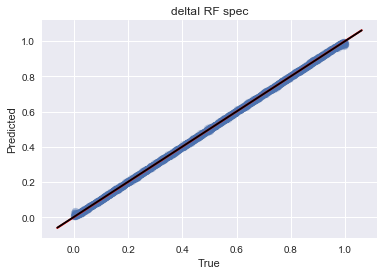

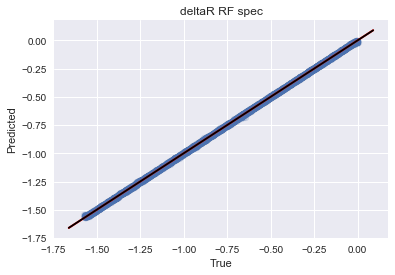

In [19]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
#plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [20]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)

### peak info

 
RMSE on test data: 0.009372121186332566 for  deltaI RF PI
R^2 Score on test data: 0.9989243184604896 for deltaI RF PI
 
RMSE on test data: 0.013705291469315909 for  deltaR RF PI
R^2 Score on test data: 0.9990918262445347 for deltaR RF PI


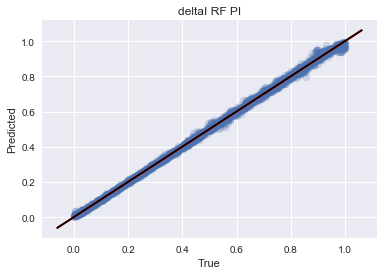

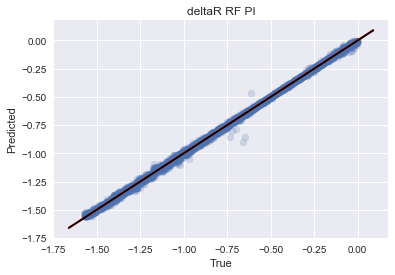

In [21]:
rs = 42
regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_pi = regr_RF_pi.fit(X2_train, Y2_train)

predictions_RF_pi = model_RF_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_RF_pi[:,0], 'deltaI RF PI')
plotSummary(Y2_test['deltaR'], predictions_RF_pi[:,1], 'deltaR RF PI')
# plotSummary(Y2_test['scale factor'], predictions_RF_pi[:,2], 'scale factor RF PI')

In [22]:
# peak info random forest feature importances 
FI_pi_RF = pd.DataFrame(regr_RF_pi.feature_importances_.T, columns = ['Peak - RF'])
FI_pi_RF.index = X2_train.columns

#print(FI_pi_RF[FI_sp_RF['Peak - RF']>0.001])
features_pi_RF = (FI_pi_RF[FI_pi_RF['Peak - RF']>0.006])
features_pi_RF_sorted = features_pi_RF.sort_values('Peak - RF', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.0032887799008269702 for  deltaI RF Combo
R^2 Score on test data: 0.9998675421981896 for deltaI RF Combo
 
RMSE on test data: 0.003443326066631342 for  deltaR RF Combo
R^2 Score on test data: 0.9999426743885349 for deltaR RF Combo


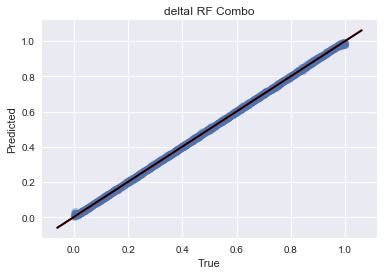

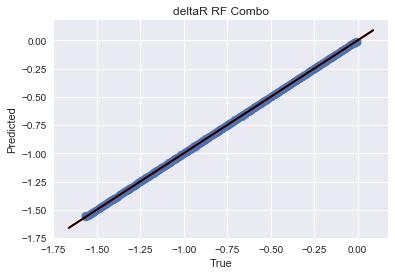

In [23]:
rs = 42
regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_both = regr_RF_both.fit(X_train, Y_train)

predictions_RF_both = model_RF_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_RF_both[:,0], 'deltaI RF Combo')
plotSummary(Y_test['deltaR'], predictions_RF_both[:,1], 'deltaR RF Combo')
#plotSummary(Y_test['scale factor'], predictions_RF_both[:,2], 'scale factor RF Combo')

In [24]:
# combined info decision tree feature importances 
FI_b_RF = pd.DataFrame(regr_RF_both.feature_importances_.T, columns = ['Both - RF'])
FI_b_RF.index = X_train.columns

#print(FI_b_RF[FI_b_RF['Both - RF']>0.001])
features_b_RF = (FI_b_RF[FI_b_RF['Both - RF']>0.006])
features_b_RF_sorted = features_b_RF.sort_values('Both - RF', ascending = False)

In [25]:
display_side_by_side(features_pi_RF_sorted, features_sp_RF_sorted, features_b_RF_sorted)

,Peak - RF
prom4,0.417552
loc4,0.209228
peak4,0.193155
loc2,0.056755
loc3,0.040101
width4,0.021021
loc1,0.012106
width3,0.008807
prom2,0.007501
peak3,0.007256


## Independent Random Forests

### spec points


Score - Random Forest: 0.9999848685491766 for deltaR IRF
 
RMSE on test data: 0.0017690662115616282 for  deltaR 10
R^2 Score on test data: 0.9999848685491766 for deltaR 10
 
RMSE on test data: 0.0026503345532452004 for  deltaI 10
R^2 Score on test data: 0.9999139780424074 for deltaI 10


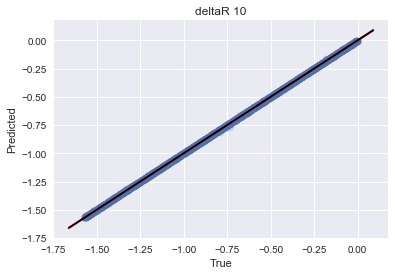

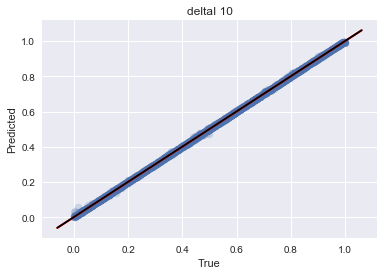

In [26]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
#model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
#predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
#plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [27]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
#FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
#FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
#features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
#features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)

### peak info


Score - Random Forest: 0.9992829538362598 for delta R IRF PI
 
RMSE on test data: 0.012178039003694381 for  deltaI IRF PI
R^2 Score on test data: 0.9992829538362599 for deltaI IRF PI
 
RMSE on test data: 0.012086772598927369 for  deltaR IRF PI
R^2 Score on test data: 0.9982109246708786 for deltaR IRF PI


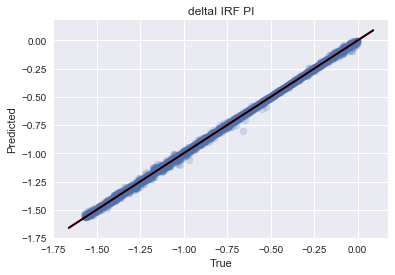

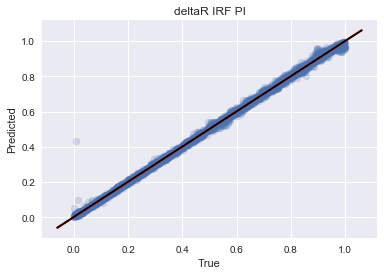

In [28]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_pi = regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_RF2_di_pi = regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])
#model_RF2_sf_pi = regr_RF2_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_RF2_dr_pi = model_RF2_dr_pi.predict(X2_test)
predictions_RF2_di_pi = model_RF2_di_pi.predict(X2_test)
#predictions_RF2_sf_pi = model_RF2_sf_pi.predict(X2_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_pi.score(X2_test, Y2_test['deltaR']), 'for delta R IRF PI')

plotSummary(Y2_test['deltaR'], predictions_RF2_dr_pi, 'deltaI IRF PI')
plotSummary(Y2_test['deltaI'], predictions_RF2_di_pi, 'deltaR IRF PI')
#plotSummary(Y2_test['scale factor'], predictions_RF2_sf_pi, 'scale factor IRF PI')

In [29]:
# peak info independent random forest feature importances delta R  
FI_pi_RF2_dr = pd.DataFrame(model_RF2_dr_pi.feature_importances_.T, columns = ['Peak - RF2_dr'])
FI_pi_RF2_dr.index = X2_train.columns

# print(FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.001])
features_pi_RF2_dr = (FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.006])
features_pi_RF2_dr_sorted = features_pi_RF2_dr.sort_values('Peak - RF2_dr', ascending = False)


# peak info independent random forest feature importances delta I 
FI_pi_RF2_di = pd.DataFrame(model_RF2_di_pi.feature_importances_.T, columns = ['Peak - RF2_di'])
FI_pi_RF2_di.index = X2_train.columns

# print(FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.001])
features_pi_RF2_di = (FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.006])
features_pi_RF2_di_sorted = features_pi_RF2_di.sort_values('Peak - RF2_di', ascending = False)

# peak info independent random forest feature importances scale factor
#FI_pi_RF2_sf = pd.DataFrame(model_RF2_sf_pi.feature_importances_.T, columns = ['Peak - RF2_sf'])
#FI_pi_RF2_sf.index = X2_train.columns

# print(FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.001])
#features_pi_RF2_sf = (FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.006])
#features_pi_RF2_sf_sorted = features_pi_RF2_sf.sort_values('Peak - RF2_sf', ascending = False)


### spec points and peak info


Score - Random Forest: 0.9999828804123623 for delta R IRF Both
 
RMSE on test data: 0.0018817002912503746 for  deltaI 10
R^2 Score on test data: 0.9999828804123624 for deltaI 10
 
RMSE on test data: 0.0026165738737770543 for  deltaR 10
R^2 Score on test data: 0.999916155626175 for deltaR 10


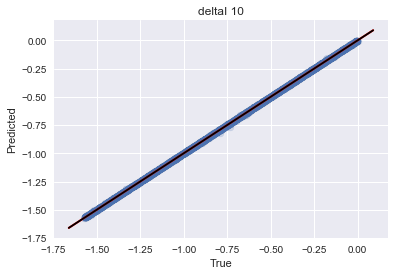

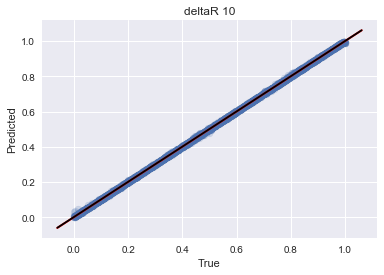

In [30]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_both = regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
model_RF2_di_both = regr_RF2_di_both.fit(X_train, Y_train['deltaI'])
#model_RF2_sf_both = regr_RF2_sf_both.fit(X_train, Y_train['scale factor'])

predictions_RF2_dr_both = model_RF2_dr_both.predict(X_test)
predictions_RF2_di_both = model_RF2_di_both.predict(X_test)
#predictions_RF2_sf_both = model_RF2_sf_both.predict(X_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_both.score(X_test, Y_test['deltaR']), 'for delta R IRF Both')

plotSummary(Y_test['deltaR'], predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], predictions_RF2_di_both, 'deltaR 10')
#plotSummary(Y_test['scale factor'], predictions_RF2_sf_both, 'deltaR IRF Both')

In [31]:
# combined info independent random forest feature importances delta R  
FI_b_RF2_dr = pd.DataFrame(model_RF2_dr_both.feature_importances_.T, columns = ['Both - RF2_dr'])
FI_b_RF2_dr.index = X_train.columns

# print(FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.001])
features_b_RF2_dr = (FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.006])
features_b_RF2_dr_sorted = features_b_RF2_dr.sort_values('Both - RF2_dr', ascending = False)


# combined info independent random forest feature importances delta I  
FI_b_RF2_di = pd.DataFrame(model_RF2_di_both.feature_importances_.T, columns = ['Both - RF2_di'])
FI_b_RF2_di.index = X_train.columns

# print(FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.001])
features_b_RF2_di = (FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.006])
features_b_RF2_di_sorted = features_b_RF2_di.sort_values('Both - RF2_di', ascending = False)

# combined info independent random forest feature importances scale factor 
#FI_b_RF2_sf = pd.DataFrame(model_RF2_sf_both.feature_importances_.T, columns = ['Both - RF2_sf'])
#FI_b_RF2_sf.index = X_train.columns

# print(FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.001])
#features_b_RF2_sf = (FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.006])
#features_b_RF2_sf_sorted = features_b_RF2_sf.sort_values('Both - RF2_sf', ascending = False)

In [32]:

#display_side_by_side(features_sp_RF2_dr_sorted, features_sp_RF2_di_sorted, features_sp_RF2_sf_sorted, features_b_RF2_dr_sorted, features_b_RF2_di_sorted, features_b_RF2_sf_sorted)
#display_side_by_side(features_pi_RF2_dr_sorted, features_pi_RF2_di_sorted, features_pi_RF2_sf_sorted)
display_side_by_side(features_sp_RF2_dr_sorted, features_sp_RF2_di_sorted,  features_b_RF2_dr_sorted, features_b_RF2_di_sorted)
display_side_by_side(features_pi_RF2_dr_sorted, features_pi_RF2_di_sorted)

,Spec - RF2_dr
E_464_mV,0.325278
E_462_mV,0.276113
E_-336_mV,0.075173
E_424_mV,0.050614
E_460_mV,0.049735
E_426_mV,0.046632
E_-198_mV,0.025156
E_56_mV,0.021456
E_-154_mV,0.020256
E_54_mV,0.019347


,Peak - RF2_dr
prom4,0.436243
peak4,0.223333
loc3,0.172152
loc4,0.080571
width4,0.037796
loc2,0.014920
width3,0.014818
width2,0.006740
,Peak - RF2_di
width1,0.494110


## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.0033973716364667445 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9998586505777768 for AdaBoost Delta I SP
 
RMSE on test data: 0.002209116827081798 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9999764044685929 for AdaBoost Delta R SP
Delta I AdaBoost Score: 0.9998586505777768
Delta R AdaBoost Score: 0.999976404468593


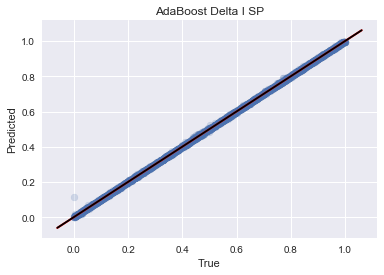

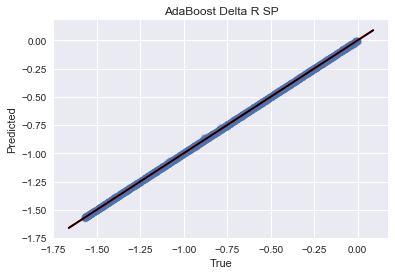

In [33]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
#predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
#print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [34]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
#FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
#FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
#features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
#features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.012601288851347116 for  AdaBoost Delta I PI
R^2 Score on test data: 0.998055366075984 for AdaBoost Delta I PI
 
RMSE on test data: 0.012965607959035473 for  AdaBoost Delta R PI
R^2 Score on test data: 0.9991872103462647 for AdaBoost Delta R PI


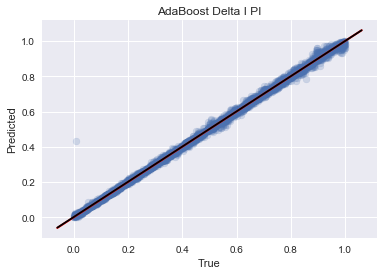

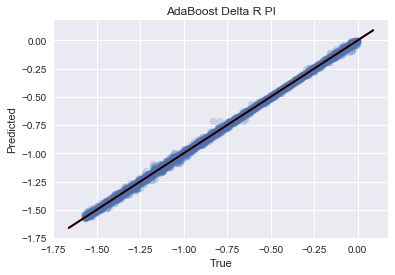

In [35]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_pi = regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_AB_dr_pi = regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
#model_AB_sf_pi = regr_AB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_AB_di_pi = model_AB_di_pi.predict(X2_test)
predictions_AB_dr_pi = model_AB_dr_pi.predict(X2_test)
#predictions_AB_sf_pi = model_AB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_AB_di_pi, 'AdaBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_AB_dr_pi, 'AdaBoost Delta R PI')
#plotSummary(Y2_test['scale factor'], predictions_AB_sf_pi, 'AdaBoost Scale Factor PI')

In [36]:
# peak info adaboost random forest feature importances delta R  
FI_pi_AB_dr = pd.DataFrame(model_AB_dr_pi.feature_importances_.T, columns = ['Peak - AB_dr'])
FI_pi_AB_dr.index = X2_train.columns

# print(FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.001])
features_pi_AB_dr = (FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.006])
features_pi_AB_dr_sorted = features_pi_AB_dr.sort_values('Peak - AB_dr', ascending = False)


# peak info adaboost random forest feature importances delta I 
FI_pi_AB_di = pd.DataFrame(model_AB_di_pi.feature_importances_.T, columns = ['Peak - AB_di'])
FI_pi_AB_di.index = X2_train.columns

# print(FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.001])
features_pi_AB_di = (FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.006])
features_pi_AB_di_sorted = features_pi_AB_di.sort_values('Peak - AB_di', ascending = False)

# peak info adaboost random forest feature importances scale factor
#FI_pi_AB_sf = pd.DataFrame(model_AB_sf_pi.feature_importances_.T, columns = ['Peak - AB_sf'])
#FI_pi_AB_sf.index = X2_train.columns

# print(FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.001])
#features_pi_AB_sf = (FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.006])
#features_pi_AB_sf_sorted = features_pi_AB_sf.sort_values('Peak - AB_sf', ascending = False)


### spec points and peak info

 
RMSE on test data: 0.0029348647970730266 for  AdaBoost Delta I Combo
R^2 Score on test data: 0.9998945165993839 for AdaBoost Delta I Combo
 
RMSE on test data: 0.002173863379527107 for  AdaBoost Delta R Combo
R^2 Score on test data: 0.9999771515423814 for AdaBoost Delta R Combo


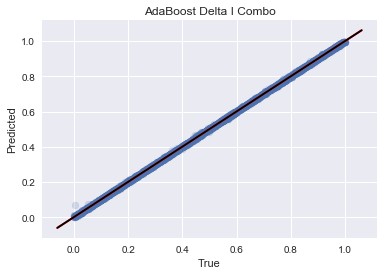

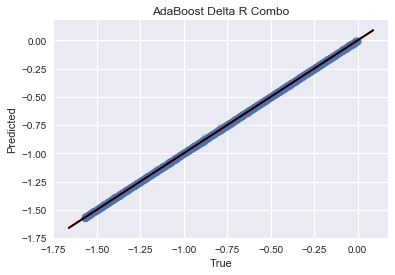

In [37]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_both = regr_AB_di_both.fit(X_train, Y_train['deltaI'])
model_AB_dr_both = regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
#model_AB_sf_both = regr_AB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_AB_di_both = model_AB_di_both.predict(X_test)
predictions_AB_dr_both = model_AB_dr_both.predict(X_test)
#predictions_AB_sf_both = model_AB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_AB_di_both, 'AdaBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_AB_dr_both, 'AdaBoost Delta R Combo')
#plotSummary(Y_test['scale factor'], predictions_AB_sf_both, 'AdaBoost Scale Factor Combo')

In [38]:
# combined info adaboost random forest feature importances delta R  
FI_b_AB_dr = pd.DataFrame(model_AB_dr_both.feature_importances_.T, columns = ['Both - AB_dr'])
FI_b_AB_dr.index = X_train.columns

# print(FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.001])
features_b_AB_dr = (FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.006])
features_b_AB_dr_sorted = features_b_AB_dr.sort_values('Both - AB_dr', ascending = False)


# combined info adaboost random forest feature importances delta I  
FI_b_AB_di = pd.DataFrame(model_AB_di_both.feature_importances_.T, columns = ['Both - AB_di'])
FI_b_AB_di.index = X_train.columns

# print(FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.001])
features_b_AB_di = (FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.006])
features_b_AB_di_sorted = features_b_AB_di.sort_values('Both - AB_di', ascending = False)

# combined info adaboost random forest feature importances scale factor 
#FI_b_AB_sf = pd.DataFrame(model_AB_sf_both.feature_importances_.T, columns = ['Both - AB_sf'])
#FI_b_AB_sf.index = X_train.columns

# print(FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.001])
#features_b_AB_sf = (FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.006])
#features_b_AB_sf_sorted = features_b_AB_sf.sort_values('Both - AB_sf', ascending = False)

In [40]:
display_side_by_side(features_sp_AB_dr_sorted, features_sp_AB_di_sorted, features_b_AB_dr_sorted, features_b_AB_di_sorted)
display_side_by_side(features_pi_AB_dr_sorted, features_pi_AB_di_sorted)

,Spec - AB_dr
E_-198_mV,0.426052
E_-6_mV,0.074089
E_-336_mV,0.073155
E_464_mV,0.061242
E_62_mV,0.056354
E_236_mV,0.050594
E_428_mV,0.042446
E_-2_mV,0.040226
E_426_mV,0.027020
E_-152_mV,0.023214


,Peak - AB_dr
prom4,0.607310
loc4,0.136258
loc3,0.083333
peak4,0.051057
width4,0.042821
loc2,0.038727
width3,0.017307
width2,0.006889
,Peak - AB_di
width1,0.502362


## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.013046144509540584 for  GradientBoost Delta I SP
R^2 Score on test data: 0.9979156420943044 for GradientBoost Delta I SP
 
RMSE on test data: 0.019502483916893052 for  GradientBoost Delta R SP
R^2 Score on test data: 0.9981610401299301 for GradientBoost Delta R SP


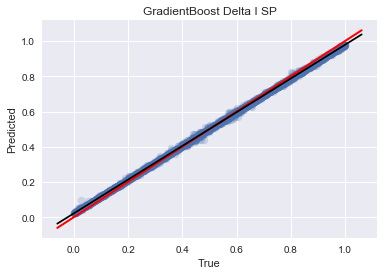

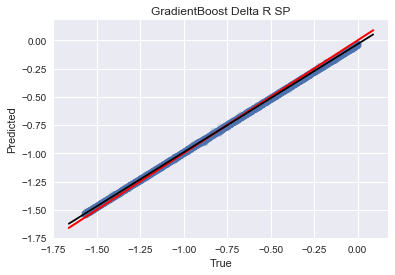

In [41]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
#predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [42]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
#FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
#FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
#features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
#features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.017843102388004965 for  GradientBoost Delta I PI
R^2 Score on test data: 0.9961010410801845 for GradientBoost Delta I PI
 
RMSE on test data: 0.02390511032642547 for  GradientBoost Delta R PI
R^2 Score on test data: 0.9972370444376423 for GradientBoost Delta R PI


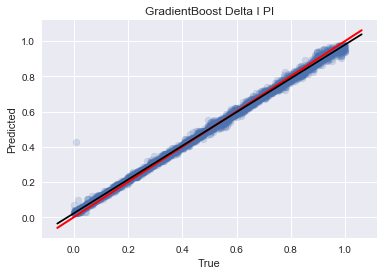

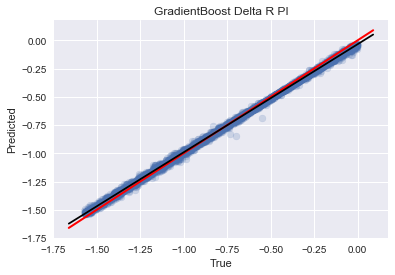

In [43]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_pi = regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_GB_dr_pi = regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
#model_GB_sf_pi = regr_GB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_GB_di_pi = model_GB_di_pi.predict(X2_test)
predictions_GB_dr_pi = model_GB_dr_pi.predict(X2_test)
#predictions_GB_sf_pi = model_GB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_GB_di_pi, 'GradientBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_GB_dr_pi, 'GradientBoost Delta R PI')
#plotSummary(Y2_test['scale factor'], predictions_GB_sf_pi, 'GradientBoost Scale Factor PI')

In [44]:
# peak info gradient boost random forest feature importances delta R  
FI_pi_GB_dr = pd.DataFrame(model_GB_dr_pi.feature_importances_.T, columns = ['Peak - GB_dr'])
FI_pi_GB_dr.index = X2_train.columns

# print(FI_pi_GB_dr[FI_pi_AB_dr['Peak - GB_dr']>0.001])
features_pi_GB_dr = (FI_pi_GB_dr[FI_pi_GB_dr['Peak - GB_dr']>0.006])
features_pi_GB_dr_sorted = features_pi_GB_dr.sort_values('Peak - GB_dr', ascending = False)


# peak info gradientboost random forest feature importances delta I 
FI_pi_GB_di = pd.DataFrame(model_GB_di_pi.feature_importances_.T, columns = ['Peak - GB_di'])
FI_pi_GB_di.index = X2_train.columns

# print(FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.001])
features_pi_GB_di = (FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.006])
features_pi_GB_di_sorted = features_pi_GB_di.sort_values('Peak - GB_di', ascending = False)


# peak info gradientboost random forest feature importances scale factor
#FI_pi_GB_sf = pd.DataFrame(model_GB_sf_pi.feature_importances_.T, columns = ['Peak - GB_sf'])
#FI_pi_GB_sf.index = X2_train.columns

# print(FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.001])
#features_pi_GB_sf = (FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.006])
#features_pi_GB_sf_sorted = features_pi_GB_sf.sort_values('Peak - GB_sf', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.013000851833139523 for  GradientBoost Delta I Combo
R^2 Score on test data: 0.9979300896227344 for GradientBoost Delta I Combo
 
RMSE on test data: 0.019497739835019602 for  GradientBoost Delta R Combo
R^2 Score on test data: 0.9981619346944504 for GradientBoost Delta R Combo


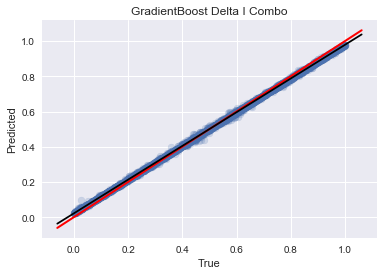

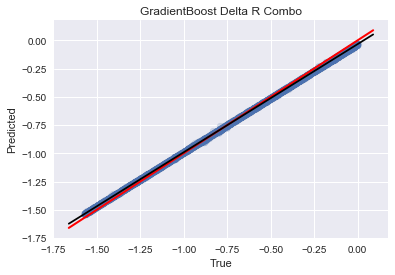

In [45]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_both = regr_GB_di_both.fit(X_train, Y_train['deltaI'])
model_GB_dr_both = regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
#model_GB_sf_both = regr_GB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_GB_di_both = model_GB_di_both.predict(X_test)
predictions_GB_dr_both = model_GB_dr_both.predict(X_test)
#predictions_GB_sf_both = model_GB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_GB_di_both, 'GradientBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_GB_dr_both, 'GradientBoost Delta R Combo')
#plotSummary(Y_test['scale factor'], predictions_GB_sf_both, 'GradientBoost Scale Factor Combo')


In [46]:
# combined info gradient boost random forest feature importances delta R  
FI_b_GB_dr = pd.DataFrame(model_GB_dr_both.feature_importances_.T, columns = ['Both - GB_dr'])
FI_b_GB_dr.index = X_train.columns

# print(FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.001])
features_b_GB_dr = (FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.006])
features_b_GB_dr_sorted = features_b_GB_dr.sort_values('Both - GB_dr', ascending = False)


# combined info gradient boost random forest feature importances delta I  
FI_b_GB_di = pd.DataFrame(model_GB_di_both.feature_importances_.T, columns = ['Both - GB_di'])
FI_b_GB_di.index = X_train.columns

# print(FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.001])
features_b_GB_di = (FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.006])
features_b_GB_di_sorted = features_b_GB_di.sort_values('Both - GB_di', ascending = False)

# combined info gradient boost random forest feature importances scale factor 
#FI_b_GB_sf = pd.DataFrame(model_GB_sf_both.feature_importances_.T, columns = ['Both - GB_sf'])
#FI_b_GB_sf.index = X_train.columns

# print(FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.001])
#features_b_GB_sf = (FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.006])
#features_b_GB_sf_sorted = features_b_GB_sf.sort_values('Both - GB_sf', ascending = False)

In [47]:
#display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted,features_sp_GB_sf_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted, features_b_GB_sf_sorted)
#display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted, features_pi_GB_sf_sorted)
display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted)
display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted)

,Spec - GB_dr
E_464_mV,0.676078
E_426_mV,0.083642
E_56_mV,0.083079
E_462_mV,0.075122
E_294_mV,0.011498
E_420_mV,0.011366
E_424_mV,0.010207
E_38_mV,0.009628
E_432_mV,0.009210
,Spec - GB_di


,Peak - GB_dr
prom4,0.651282
loc3,0.229727
width4,0.050155
loc4,0.033763
peak4,0.009322
width2,0.007181
loc2,0.006127
,Peak - GB_di
width1,0.493515
loc2,0.370360


In [48]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_462_mV,0.214915
E_464_mV,0.179183
E_-198_mV,0.053599
E_460_mV,0.053480
E_-284_mV,0.048608
E_-192_mV,0.037257
E_-336_mV,0.036854
E_242_mV,0.031449
E_-282_mV,0.019110
E_54_mV,0.017852


In [49]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_462_mV,0.214915
E_464_mV,0.179183
E_-198_mV,0.053599
E_460_mV,0.053480
E_-284_mV,0.048608
E_-192_mV,0.037257
E_-336_mV,0.036854
E_242_mV,0.031449
E_-282_mV,0.019110
E_54_mV,0.017852


In [50]:
#display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

In [51]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_dr_sorted,features_pi_AB_dr_sorted,features_pi_RF2_dr_sorted)

,Peak - RF
prom4,0.417552
loc4,0.209228
peak4,0.193155
loc2,0.056755
loc3,0.040101
width4,0.021021
loc1,0.012106
width3,0.008807
prom2,0.007501
peak3,0.007256


In [52]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_di_sorted,features_pi_AB_di_sorted,features_pi_RF2_di_sorted)

,Peak - RF
prom4,0.417552
loc4,0.209228
peak4,0.193155
loc2,0.056755
loc3,0.040101
width4,0.021021
loc1,0.012106
width3,0.008807
prom2,0.007501
peak3,0.007256


In [53]:
#display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_sf_sorted,features_pi_AB_sf_sorted,features_pi_RF2_sf_sorted)

In [54]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_dr_sorted,features_b_AB_dr_sorted,features_b_RF2_dr_sorted)

,Both - RF
E_462_mV,0.214935
E_464_mV,0.179253
E_-198_mV,0.053639
E_460_mV,0.053509
E_-284_mV,0.046218
E_-192_mV,0.037167
E_-336_mV,0.036794
E_242_mV,0.031240
E_-282_mV,0.019112
E_54_mV,0.017812


In [55]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_di_sorted,features_b_AB_di_sorted,features_b_RF2_di_sorted)

,Both - RF
E_462_mV,0.214935
E_464_mV,0.179253
E_-198_mV,0.053639
E_460_mV,0.053509
E_-284_mV,0.046218
E_-192_mV,0.037167
E_-336_mV,0.036794
E_242_mV,0.031240
E_-282_mV,0.019112
E_54_mV,0.017812


In [56]:
#display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_sf_sorted,features_b_AB_sf_sorted,features_b_RF2_sf_sorted)


## Testing the Models on the Experimental Data



In [57]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names
col_names_exp_both = col_names_both[2:]

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_peakinfo.csv', header = None, names = col_names3)

In [58]:
# energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# col_names1a = energy_names[50:] # use for taking out first peak specs 
# exp_data_sp = exp_data_sp[col_names1a] # use for taking out first peak specs 
exp_data_sp

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.63853,0.63594,0.64731,0.65819,0.67897,0.708,0.7397,0.7855,0.84717,0.91786,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [59]:
## Use these if want to remove first peak info
# peak_names2 = ['peak2', 'peak3', 'peak4']
# prom_names2 = ['prom2', 'prom3', 'prom4']
# locs_names2 = ['loc2', 'loc3', 'loc4']
# width_names2 = ['width2', 'width3', 'width4']
# pi_names = peak_names2 + locs_names2 + width_names2 + prom_names2
# exp_data_pi = exp_data_pi[pi_names]
exp_data_pi

,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,1.7917,1.9262,1.8662,1.4495,-0.362,-0.242,-0.074,0.134,0.026521,0.032045,0.039422,0.04612,1.1543,1.2902,1.1855,0.57098


In [60]:
# Use these if want to remove first peak info 
#subset = 5 
#energy_names2 = energy_names[50:]
#exp_data_sp2 = exp_data_sp[energy_names2]
#exp_data_both = exp_data_pi.join(exp_data_sp2, how = 'left')
exp_data_both = exp_data_pi.join(exp_data_sp, how = 'left')
exp_data_both


,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,1.7917,1.9262,1.8662,1.4495,-0.362,-0.242,-0.074,0.134,0.026521,0.032045,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [62]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                          #   r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T

pred_phase_DT_pi = np.append(regr_DT_pi.predict(exp_data_pi), 
                            r2_score(Y1_test['deltaI'], predictions_DT_pi[:,0])).reshape(3,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['deltaR'], predictions_DT_pi[:,1])).reshape(4,1).T
#pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            #r2_score(Y1_test['scale factor'], predictions_DT_pi[:,2])).reshape(6,1).T

pred_phase_DT_both = np.append(regr_DT_both.predict(exp_data_both), 
                            r2_score(Y_test['deltaI'], predictions_DT_both[:,0])).reshape(3,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['deltaR'], predictions_DT_both[:,1])).reshape(4,1).T
#pred_phase_DT_both = np.append(pred_phase_DT_both, 
                      #      r2_score(Y_test['scale factor'], predictions_DT_both[:,2])).reshape(6,1).T

In [64]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)
pred_phase_RF_pi = regr_RF_pi.predict(exp_data_pi)
pred_phase_RF_both = regr_RF_both.predict(exp_data_both)

pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
#pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)

pred_phase_AB_R_pi = model_AB_dr_pi.predict(exp_data_pi)
pred_phase_AB_I_pi = model_AB_di_pi.predict(exp_data_pi)
#pred_phase_AB_sf_pi = model_AB_sf_pi.predict(exp_data_pi)

pred_phase_AB_R_both = model_AB_dr_both.predict(exp_data_both)
pred_phase_AB_I_both = model_AB_di_both.predict(exp_data_both)
#pred_phase_AB_sf_both = model_AB_sf_both.predict(exp_data_both)

pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
#pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)

pred_phase_GB_di_pi = model_GB_di_pi.predict(exp_data_pi)
pred_phase_GB_dr_pi = model_GB_dr_pi.predict(exp_data_pi)
#pred_phase_GB_sf_pi = model_GB_sf_pi.predict(exp_data_pi)

pred_phase_GB_di_both = model_GB_di_both.predict(exp_data_both)
pred_phase_GB_dr_both = model_GB_dr_both.predict(exp_data_both)
#pred_phase_GB_sf_both = model_GB_sf_both.predict(exp_data_both)

pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
#pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)

pred_phase_IRF_di_pi = model_RF2_di_pi.predict(exp_data_pi)
pred_phase_IRF_dr_pi = model_RF2_dr_pi.predict(exp_data_pi)
#pred_phase_IRF_sf_pi = model_RF2_sf_pi.predict(exp_data_pi)

pred_phase_IRF_di_both = model_RF2_di_both.predict(exp_data_both)
pred_phase_IRF_dr_both = model_RF2_dr_both.predict(exp_data_both)
#pred_phase_IRF_sf_both = model_RF2_sf_both.predict(exp_data_both)


In [65]:
#predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])


In [66]:
#new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree peak info')
new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree peak info')
predictedPhases = predictedPhases.append(new_test)

In [67]:
#new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree spec points and peak info')
new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], name = 'Decision Tree spec points and peak info')
predictedPhases = predictedPhases.append(new_1)

In [68]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
#RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

RF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_pi[:,0])
RF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_pi[:,1])
#RF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_pi[:,2])

RF_b_di_r2score = r2_score(Y_test['deltaI'], predictions_RF_both[:,0])
RF_b_dr_r2score = r2_score(Y_test['deltaR'], predictions_RF_both[:,1])
#RF_b_sf_r2score = r2_score(Y_test['scale factor'], predictions_RF_both[:,2])

In [69]:
#predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
#predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], pred_phase_RF_pi[0,2], RF_pi_di_r2score, RF_pi_dr_r2score, RF_pi_sf_r2score )
#predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], pred_phase_RF_both[0,2], RF_b_di_r2score, RF_b_dr_r2score, RF_b_sf_r2score)

predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], RF_sp_di_r2score, RF_sp_dr_r2score)
predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], RF_pi_di_r2score, RF_pi_dr_r2score )
predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], RF_b_di_r2score, RF_b_dr_r2score)

In [70]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
#AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)

AB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_pi)
AB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_pi)
#AB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_pi)

AB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_both)
AB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_both)
#AB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_both)

In [71]:
#predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
#predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], pred_phase_AB_sf_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score, AB_pi_sf_r2score) 
#predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0], pred_phase_AB_sf_both[0], AB_b_di_r2score, AB_b_dr_r2score, AB_b_sf_r2score)



predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0],  AB_sp_di_r2score, AB_sp_dr_r2score)
predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score) 
predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0],  AB_b_di_r2score, AB_b_dr_r2score)


In [72]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
#GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)

GB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_pi)
GB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_pi)
#GB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_pi)

GB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_both)
GB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_both)
#GB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_both)

In [75]:
#predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
#predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0], pred_phase_GB_sf_pi[0], GB_pi_di_r2score, GB_pi_dr_r2score, GB_pi_sf_r2score) 
#predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], pred_phase_GB_dr_both[0], pred_phase_GB_sf_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_sf_r2score)


predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score)
predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0],  GB_pi_di_r2score, GB_pi_dr_r2score) 
predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_di_r2score)


In [76]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
#IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

IRF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_pi)
IRF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_pi)
#IRF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_pi)

IRF_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_both)
IRF_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_both)
#IRF_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_both)

In [77]:
#predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
#predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  pred_phase_IRF_sf_pi[0], IRF_pi_di_r2score, IRF_pi_dr_r2score, IRF_pi_sf_r2score)
#predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],  pred_phase_IRF_sf_both[0], IRF_b_di_r2score, IRF_b_dr_r2score, IRF_b_sf_r2score)


predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score)
predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  IRF_pi_di_r2score, IRF_pi_dr_r2score)
predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],   IRF_b_di_r2score, IRF_b_dr_r2score)

In [78]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,0.014837,-0.048284,0.998798,0.999435
Decision Tree peak info,0.002571,-0.141630,0.998038,0.998861
Decision Tree spec points and peak info,0.007704,-0.085542,0.998793,0.999461
Random Forest spec points,0.017980,-0.073153,0.999866,0.999945
Random Forest peak info,0.022686,-0.161894,0.998924,0.999092
Random Forest spec points and peak info,0.014947,-0.082615,0.999868,0.999943
AdaBoost spec points,0.002288,-0.033647,0.999859,0.999976
AdaBoost peak info,0.004584,-0.104230,0.998055,0.999187
AdaBoost spec points and peak info,0.002205,-0.033612,0.999895,0.999977
Gradient Boosting spec points,0.022211,-0.068356,0.997916,0.998161


In [79]:
# Sorting Predicted Phases Dataframe 
predictedPhases.sort_values(by=['deltaR score'])

,deltaI,deltaR,deltaI score,deltaR score
Gradient Boosting peak info,0.023595,-0.109997,0.996101,0.997237
Gradient Boosting spec points and peak info,0.021928,0.997930,0.998162,0.997930
Gradient Boosting spec points,0.022211,-0.068356,0.997916,0.998161
Decision Tree peak info,0.002571,-0.141630,0.998038,0.998861
Random Forest peak info,0.022686,-0.161894,0.998924,0.999092
AdaBoost peak info,0.004584,-0.104230,0.998055,0.999187
Independent Random Forests peak info,0.002591,-0.096015,0.998211,0.999283
Decision Tree spec points,0.014837,-0.048284,0.998798,0.999435
Decision Tree spec points and peak info,0.007704,-0.085542,0.998793,0.999461
Random Forest spec points and peak info,0.014947,-0.082615,0.999868,0.999943


In [80]:
# Predictions with 0.95 or lower scores excluded 
GoodPredictedDeltaI = predictedPhases
GoodPredictedDeltaR = predictedPhases
#GoodPredictedScaleFactor = predictedPhases.drop(['Decision Tree peak info', 'Decision Tree spec points', 'Decision Tree spec points and peak info', 'Random Forest peak info'], axis = 0)


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
#scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
#print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  -0.007271624073440639  +  0.010919314576454725 *i


In [81]:
#predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Hexagon/predictions_PS_sf_FI_180721.csv')
#predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Hexagon/scores_PS_sf_FI_180721.csv')

predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Hexagon/predictions_PS_FI_180727.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Hexagon/scores_PS_FI_180727.csv')

In [82]:
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_RF_= pd.Series(model_RF_both.feature_importances_, index = X_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_both.feature_importances_, index = X_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_both.feature_importances_, index = X_train.columns)
#importance_IRF_sf = pd.Series(model_RF2_sf_both.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_both.feature_importances_, index = X_train.columns)
importance_ARF_i = pd.Series(model_AB_di_both.feature_importances_, index = X_train.columns)
#importance_ARF_sf = pd.Series(model_AB_sf_both.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_both.feature_importances_, index = X_train.columns)
importance_GRF_i = pd.Series(model_GB_di_both.feature_importances_, index = X_train.columns)
#importance_GRF_sf = pd.Series(model_GB_sf_both.feature_importances_, index = X_train.columns)

In [83]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
#IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
#ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
#GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_230_mV     1
E_496_mV     1
E_466_mV     1
E_458_mV     1
E_420_mV     1
E_402_mV     1
E_394_mV     1
E_38_mV      1
E_294_mV     1
E_242_mV     1
E_148_mV     1
E_-398_mV    1
E_-328_mV    1
E_62_mV      1
E_-262_mV    1
E_-168_mV    1
E_-190_mV    1
E_-322_mV    1
E_-318_mV    1
E_-312_mV    1
E_-284_mV    1
E_-192_mV    2
E_432_mV     2
E_-282_mV    2
E_-154_mV    2
E_56_mV      2
E_-394_mV    2
E_326_mV     2
E_-324_mV    2
E_426_mV     3
E_430_mV     3
E_-400_mV    3
E_-326_mV    3
E_460_mV     3
E_396_mV     3
E_-336_mV    3
E_54_mV      3
E_-198_mV    3
E_-332_mV    3
E_424_mV     4
E_464_mV     4
E_462_mV     5
dtype: int64

In [84]:
#sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
#sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
#sf_tops_count = sf_tops.groupby(level=[0]).size()
#sf_tops_count.sort_values(axis = 0)
#sf_tops_count = sf_tops_count.sort_values()
#sf_tops_count

Text(0,0.5,'Feature Importance')

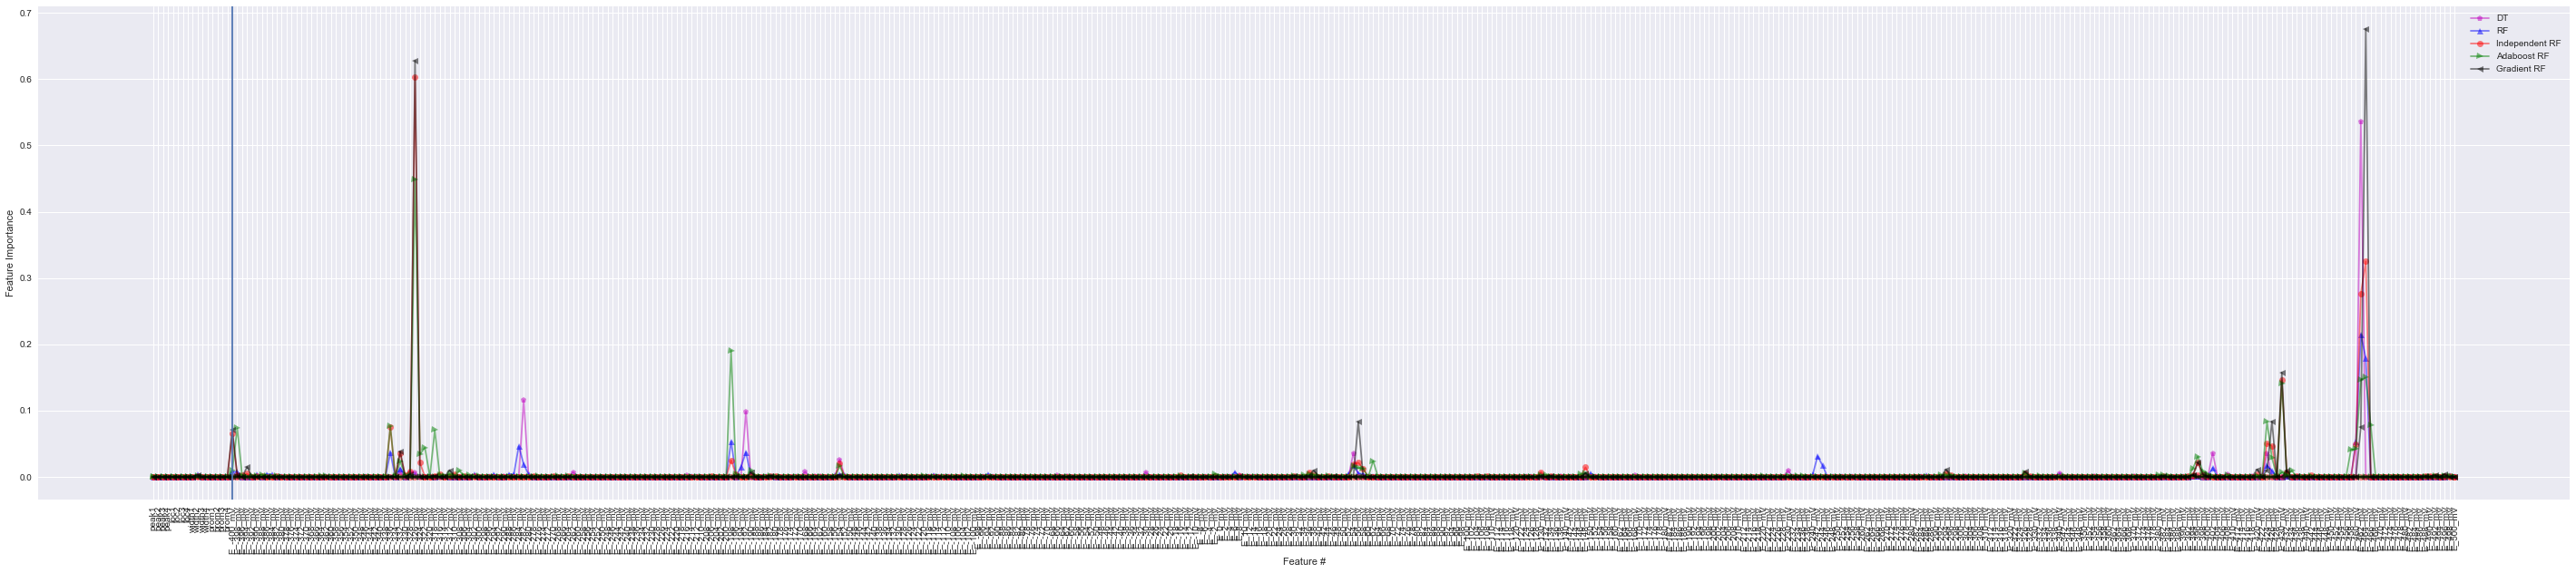

In [85]:
Features = linspace(0,467, 467)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

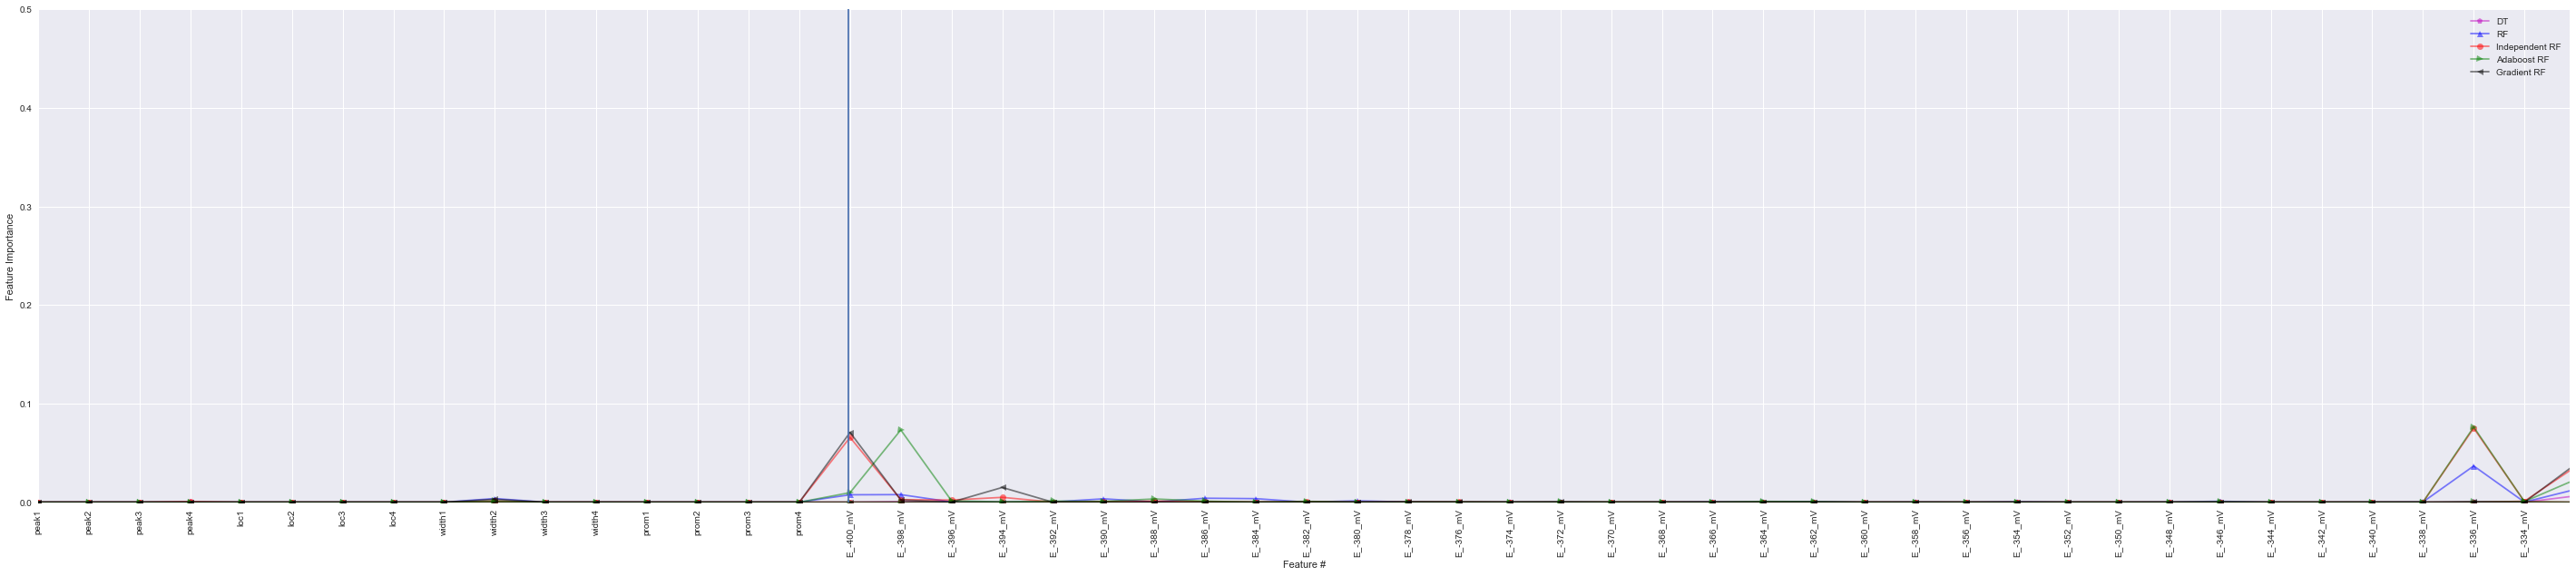

In [86]:
Features = linspace(0,467, 467)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.50])
xlim([0, 50])